# Exercises - GEO4902-01 - General modeling concepts

[Save google-collab as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 01A - How to access the latest weather forecast:

In [1]:
# import python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cy
from matplotlib.dates import DateFormatter

### **1.Open the latest weather forecast from the Norwegian Arctic forecast system (AROME Arctic) as already implemented in the script.**

Specify the file on the thredds server. For example the full file of latest forecast of the AROME Arctic weather model. Note, at this point only metadata is retrieved.

To get to the dataset you go to the MetCoOp website: https://thredds.met.no/thredds/catalog/mepslatest/catalog.html
and pick up the latest .nc (netcdf) file.

In [2]:
url='https://thredds.met.no/thredds/dodsC/aromearcticlatest/latest/arome_arctic_lagged_12_h_latest_2_5km_latest.nc'
dataset = xr.open_dataset(url)

### **2. Make yourself familiar with the metadata of the datafile.**

### Metadata

In [3]:
dataset

<xarray.Dataset> Size: 10GB
Dimensions:                    (time: 58, ensemble_member: 4, pressure: 2,
                                height_above_msl: 1, height0: 1, height1: 1,
                                height2: 1, x: 739, y: 949)
Coordinates:
  * time                       (time) datetime64[ns] 464B 2024-09-17T09:00:00...
  * ensemble_member            (ensemble_member) int16 8B 0 1 2 3
  * pressure                   (pressure) float32 8B 850.0 925.0
  * height_above_msl           (height_above_msl) float32 4B 0.0
  * height0                    (height0) float32 4B 2.0
  * height1                    (height1) float32 4B 0.0
  * height2                    (height2) float32 4B 10.0
  * x                          (x) float32 3kB 2.786e+05 2.811e+05 ... 2.124e+06
  * y                          (y) float32 4kB -8.98e+05 ... 1.472e+06
    longitude                  (y, x) float64 6MB ...
    latitude                   (y, x) float64 6MB ...
Data variables: (12/15)
    forecast_reference_time    datetime64[ns] 8B ...
    projection_lambert         int32 4B ...
    x_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    y_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_pl         (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_2m         (time, height0, ensemble_member, y, x) float32 651MB ...
    ...                         ...
    cloud_area_fraction        (time, height1, ensemble_member, y, x) float32 651MB ...
    air_pressure_at_sea_level  (time, height_above_msl, ensemble_member, y, x) float32 651MB ...
    precipitation_amount_acc   (time, height1, ensemble_member, y, x) float32 651MB ...
    snowfall_amount_acc        (time, height1, ensemble_member, y, x) float32 651MB ...
    wind_speed_of_gust         (time, height2, ensemble_member, y, x) float32 651MB ...
    fog_area_fraction          (time, height1, ensemble_member, y, x) float32 651MB ...
Attributes: (12/23)
    Conventions:                     CF-1.6, ACDD
    institution:                     Norwegian Meteorological Institute, MET ...
    institution_short_name:          NO/MET
    creator_url:                     met.no
    source:                          AROME-Arctic 2.5km
    title:                           AROME_Arctic 2.5km
    ...                              ...
    dataset_production_status:       Active
    iso_topic_category:              climatologyMeteorologyAtmosphere
    spatial_representation:          grid
    naming_authority:                no.met
    history:                         2024-09-17T11:22:26 creation by fimex
    DODS_EXTRA.Unlimited_Dimension:  time

### **3. Plot a single point-forecast and a surface map of the 2-meter temperature.**

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [4]:
# Function to find a specific lat/lon location 

import math
import numpy as np

def findindex(alat,alon,plat,plon):
    
    #finding identical location of **position** plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    
    #finding the minumum of the maximum differences:
        
    c = np.maximum(abslat,abslon)
    x, y = np.where(c == np.min(c))
    
    #-But why minumum of maximum and not minimum of minumum?
    #-By looking for the minimum of the maximum differences, the function ensures that a location isn't chosen based on a very small difference 
    #in just one dimension (either latitude or longitude). Instead, it tries to find a balanced point that's reasonably close in both dimensions.
    
   #these are the **indices** of latitude and longitude, that will indicate the right values inside these arrays
    
    x=int(x) 
    y=int(y)
   
    return (x,y)

In [5]:
#Find a specific location, for example for Longyearbyen

lon = 15.46; lat= 78.24
[xloc,yloc] = findindex(dataset.latitude,dataset.longitude,lat,lon) 

#Printing the coordinates, to make sure we got them right ;)
print('longitude =', float(dataset.longitude[xloc,yloc].values.round(2)))
print('latitude =', float(dataset.latitude[xloc,yloc].values.round(2)))

t2m_point = dataset.air_temperature_2m[:,0,1,xloc,yloc]-273 #you are choosing the model (4), this is why you don't get an ensemble!

#Note the number of dimentsions of the temperature array and cross-check with the metadata:
print(dataset.air_temperature_2m.shape)

/tmp/ipykernel_77735/2988361417.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_77735/2988361417.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


longitude = 15.49
latitude = 78.25
(58, 1, 4, 949, 739)


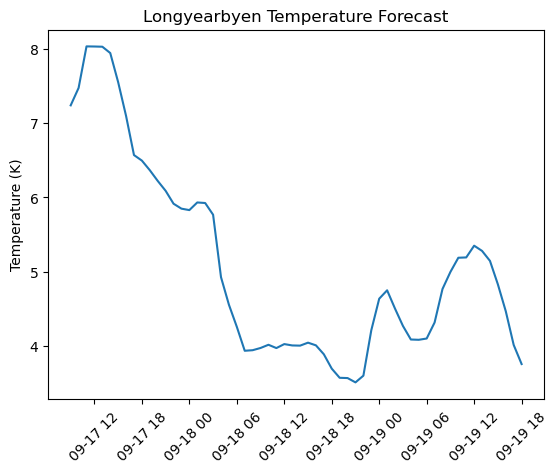

In [6]:
from matplotlib import pyplot as plt

plt.plot(dataset.time, t2m_point, '-')
plt.xticks(rotation=45)
plt.ylabel('Temperature (K)')
plt.title("Longyearbyen Temperature Forecast")
plt.show()

### Plot one forecast on a map

Choose ensemble member and timestep (see indexes from the metadata)

In [7]:
ensemble_mem = 1
timestep = 2

t2m_area = dataset.air_temperature_2m[timestep,0,ensemble_mem,:,:]

Choose the type of the map from: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

Text(0.5, 0.98, 'Temperature forecast')

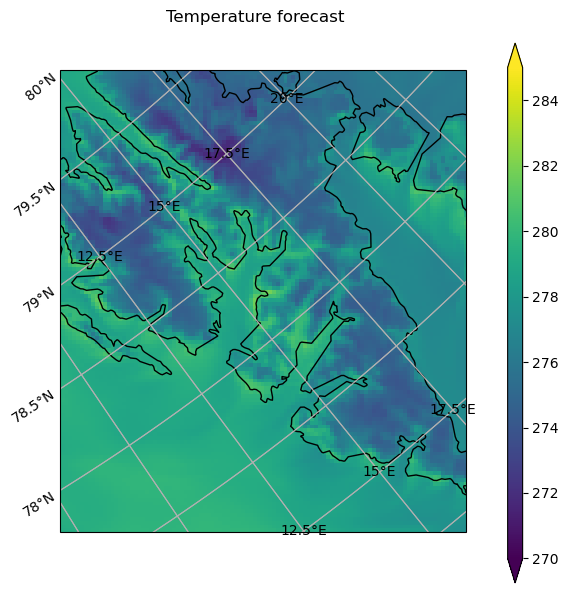

In [8]:
projection = cy.crs.LambertConformal(central_longitude =dataset.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =dataset.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = dataset.projection_lambert.standard_parallel)
fig = plt.figure(figsize=[6, 6])

ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([lon - 1.5, lon + 1.5, lat-1.5, lat+1.5], cy.crs.PlateCarree())

ax.gridlines()
ax.add_feature(cy.feature.COASTLINE, zorder=2) 
cf = ax.pcolormesh(t2m_area.longitude,t2m_area.latitude,t2m_area[:,:],transform=cy.crs.PlateCarree(), zorder=1)
cf.set_clim(270,285)
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
   
cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')

fig.suptitle('Temperature forecast')

### **4. Make your own weather forecast for a certain region + location. Describe how the weather system will change (e.g. surface pressure or Geopotential height) and the implications for wind, temperature, and precipitation for the coming days. Compare it with yr.no.** 

As a location, we can choose Oslo, Bindern with:
* Latitude: 59.9423º N
* Longitude: 10.72º E

Then we move exactly as before:

If you choose to go to the MEPS catalogues: https://thredds.met.no/thredds/catalog/aromearcticarchive/catalog.html, you just pick up the latest .nc file form the latest date in the archive
  (not the lagged values, though):

In [9]:
url = 'https://thredds.met.no/thredds/dodsC/aromearcticarchive/2024/09/13/arome_arctic_det_2_5km_20240913T09Z.nc'
my_ds = xr.open_dataset(url)
my_ds

<xarray.Dataset> Size: 224GB
Dimensions:                                                                      (
                                                                                  time: 67,
                                                                                  mean_sea_level: 1,
                                                                                  surface: 1,
                                                                                  pressure: 13,
                                                                                  height_above_msl: 1,
                                                                                  ...
                                                                                  adiabatic_condensation_level: 1,
                                                                                  maximum_wind_level: 1,
                                                                                  tropopause: 1,
                                                                                  top_of_atmosphere: 1,
                                                                                  x: 739,
                                                                                  y: 949)
Coordinates: (12/27)
  * time                                                                         (time) datetime64[ns] 536B ...
  * mean_sea_level                                                               (mean_sea_level) int16 2B ...
  * surface                                                                      (surface) int16 2B ...
  * pressure                                                                     (pressure) float32 52B ...
  * height_above_msl                                                             (height_above_msl) float32 4B ...
  * height0                                                                      (height0) float32 4B ...
    ...                                                                           ...
  * tropopause                                                                   (tropopause) int16 2B ...
  * top_of_atmosphere                                                            (top_of_atmosphere) int16 2B ...
  * x                                                                            (x) float32 3kB ...
  * y                                                                            (y) float32 4kB ...
    longitude                                                                    (y, x) float64 6MB ...
    latitude                                                                     (y, x) float64 6MB ...
Data variables: (12/233)
    forecast_reference_time                                                      datetime64[ns] 8B ...
    p0                                                                           float64 8B ...
    ap                                                                           (hybrid) float64 520B ...
    b                                                                            (hybrid) float64 520B ...
    projection_lambert                                                           int32 4B ...
    integral_of_toa_net_downward_shortwave_flux_wrt_time_assuming_clear_sky      (time, top_of_atmosphere, y, x) float32 188MB ...
    ...                                                                           ...
    SFX_FMV                                                                      (time, y, x) float32 188MB ...
    SFX_CD                                                                       (time, y, x) float32 188MB ...
    SFX_CH                                                                       (time, y, x) float32 188MB ...
    SFX_CE                                                                       (time, y, x) float32 188MB ...
    SFX_Z0                                                                       (time, y, x) float32 188MB ...
    SFX_Z0H 

Choose the closest points to the Blindern station, just as before:

In [10]:
# find the x and y coordinates of Blindern station
lat = 59.9423
lon = 10.72
print(my_ds.latitude)
Blindern_x, Blindern_y = findindex(my_ds.latitude, my_ds.longitude, lat, lon)
print(Blindern_x, Blindern_y)

timestep=8

#Printing the coordinates, to make sure we got them right ;)
print('longitude =', float(my_ds.longitude[Blindern_x,Blindern_y].values.round(2)))
print('latitude =', float(my_ds.latitude[Blindern_x,Blindern_y].values.round(2)))

<xarray.DataArray 'latitude' (y: 949, x: 739)> Size: 6MB
[701311 values with dtype=float64]
Coordinates:
  * x          (x) float32 3kB 2.786e+05 2.811e+05 ... 2.121e+06 2.124e+06
  * y          (y) float32 4kB -8.98e+05 -8.955e+05 ... 1.47e+06 1.472e+06
    longitude  (y, x) float64 6MB ...
    latitude   (y, x) float64 6MB ...
Attributes:
    units:          degree_north
    long_name:      latitude
    standard_name:  latitude
    _ChunkSizes:    [949 739]
0 625
longitude = 14.49
latitude = 63.75


/tmp/ipykernel_77735/2988361417.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_77735/2988361417.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


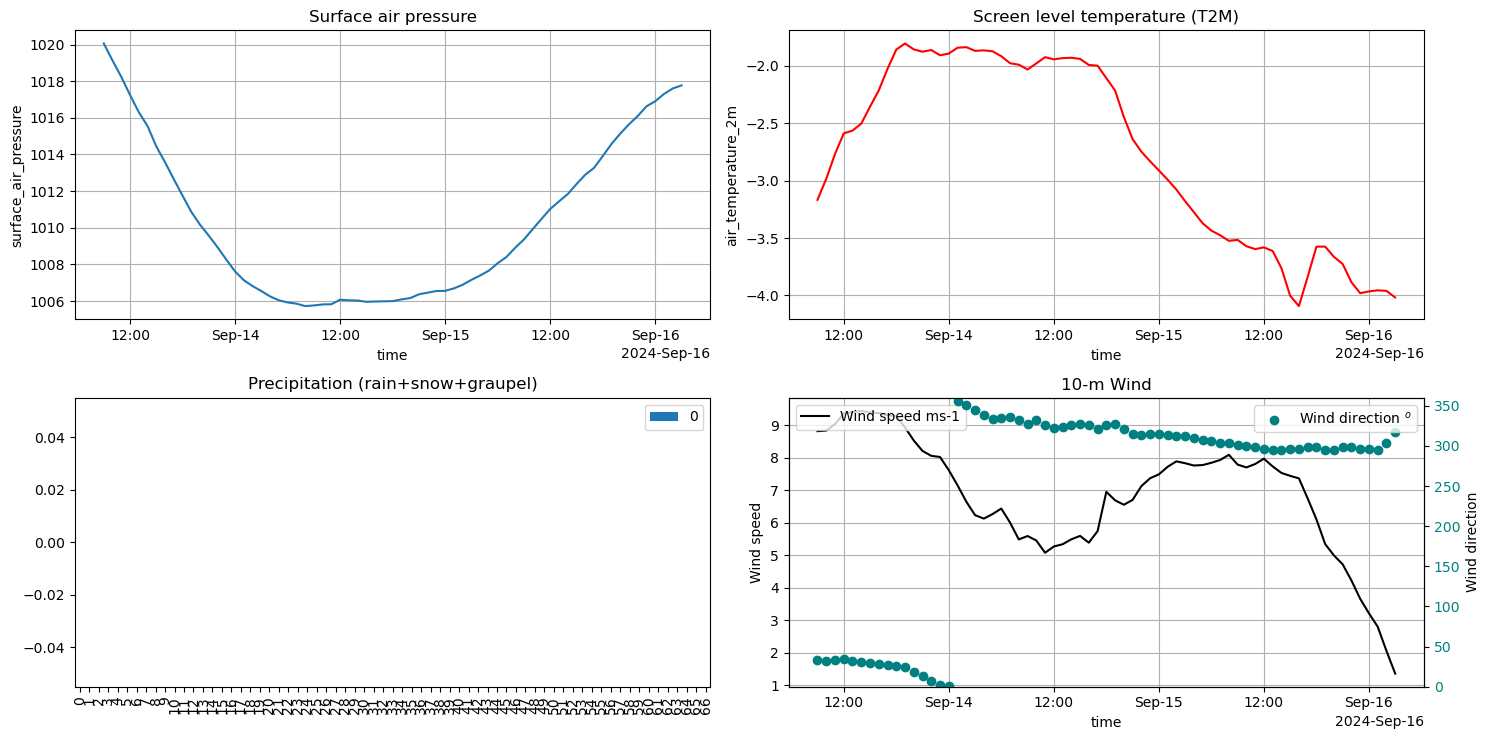

In [11]:
# Define a function to plot the point forecast since we want to plot it for other stations as well
def plt_point_forecast(axsm, dataset, xloc, yloc):

  # Define the date format
  date_form = DateFormatter("%D/%M %H:00")
  
  for axs in axsm.flatten():
    axs.grid()
    axs.tick_params(axis='x', labelrotation=0, )
    plt.setp(axs.get_xticklabels(), horizontalalignment="center")
    axs.xaxis.set_major_formatter(date_form)      
    
  axs = axsm.flatten()

  # surface air pressure
  (dataset.surface_air_pressure.isel(height0 = 0, x = xloc, y = yloc)/100).plot(ax = axs[0])
  axs[0].set_title(dataset.surface_air_pressure.attrs['long_name'])

  # temperature
  (dataset.air_temperature_2m.isel(height1 = 0, x = xloc, y = yloc)-273.15).plot(ax = axs[1], color = 'r')
  axs[1].set_title(dataset.air_temperature_2m.attrs['long_name'])

  # precipitation [kg/m2]
  precip =  (dataset.rainfall_amount.isel(height0 = 0, x = xloc, y = yloc) + \
  dataset.snowfall_amount.isel(height0 = 0, x = xloc, y = yloc) + \
  dataset.graupelfall_amount.isel(height0 = 0, x = xloc, y = yloc)).to_series()
  precip.reset_index().plot.bar( y = 0, ax = axs[2])
  axs[2].set_title('Precipitation (rain+snow+graupel)')

  # wind
  np.sqrt(dataset.x_wind_10m.isel(height7 = 0, x = xloc, y = yloc)**2 + dataset.y_wind_10m.isel(height7 = 0, x = xloc, y = yloc)**2).plot(ax = axs[3], label = 'Wind speed ms-1', color = 'k')
  axs[3].legend(loc="upper left")
  axs[3].set_ylabel('Wind speed')
  axs[3].set_title('')
  axs[3].tick_params(axis='y', labelcolor='k')

  # calculate wind direction from x and y
  wind_dir  = np.arctan2(dataset.y_wind_10m.isel(height7 = 0,  x = xloc, y = yloc) ,
                          dataset.x_wind_10m.isel(height7 = 0,  x = xloc, y = yloc))    # wind is now in rads
  wind_dir  = (270 - np.rad2deg(wind_dir ))     # wind is now in deg
  # adjust if values larger 360
  _larger360 = np.where(wind_dir[:,] > 360.)
  _larger360 = np.array(_larger360).flatten()
  wind_dir[_larger360] = wind_dir[_larger360] - 360.

  axs3 = axs[3].twinx()
  axs3.scatter(x=wind_dir.time.values, y =wind_dir.values, color='teal',label = 'Wind direction $^{o}$')
  axs3.set_ylim(0, 360)
  # wind_dir.plot(ax = axs3, label = 'Wind direction $^{o}$',color = 'teal')
  axs3.legend(loc = "upper right")
  axs3.set_ylabel('Wind direction')
  axs3.set_title('10-m Wind')
  axs3.tick_params(axis='y', labelcolor='teal')  

  plt.tight_layout()

# Plot the point forecast
fig, axsm = plt.subplots(2,2, figsize=[15,7.5])# #sharex=True)
                         
axs = axsm.flatten()

plt_point_forecast(axsm, my_ds, Blindern_x, Blindern_y)

Note from Franziska: What the precipitation plot shows is the forecasted precipitation accumulation within one hour. In detail, the y-axis is the precipitation amount and the x-axis is the time step.

Comparison with [yr.no](https://www.yr.no/nb/v%C3%A6rvarsel/daglig-tabell/1-72837/Norge/Oslo/Oslo/Oslo):

It makes it a lot easier if you click on 'graf', so you can have their respective plots.

Be careful of the units!

### **5. Plot the temperature and wind forecast from AROMEArctic as a map for 2020 February 04 14:00 UTC. And a point-forecast initialized on 2020 February 04 00:00 UTC  for Tromsø. The forecast date is related to a polar low which made landfall in 2020 directly at Tromsø.**

Now we're making the forecast for an other place, at some time in the past:

We choose 4th of Feb 2020 from the MEPS old archive: https://thredds.met.no/thredds/catalog/mepsoldarchive/catalog.html

In [12]:
url = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/2020/02/04/meps_mbr1_full_2_5km_20200204T00Z.nc'

ds_pl = xr.open_dataset(url)
ds_pl

<xarray.Dataset> Size: 353GB
Dimensions:                                                                      (
                                                                                  time: 67,
                                                                                  height_above_msl: 1,
                                                                                  height0: 1,
                                                                                  height1: 1,
                                                                                  height2: 1,
                                                                                  ...
                                                                                  hybrid: 65,
                                                                                  atmosphere_as_single_layer: 1,
                                                                                  grib1_vLevel6: 1,
                                                                                  top_of_atmosphere: 1,
                                                                                  x: 889,
                                                                                  y: 949)
Coordinates: (12/18)
  * time                                                                         (time) datetime64[ns] 536B ...
  * height_above_msl                                                             (height_above_msl) float32 4B ...
  * height0                                                                      (height0) float32 4B ...
  * height1                                                                      (height1) float32 4B ...
  * height2                                                                      (height2) float32 4B ...
  * height3                                                                      (height3) float32 12B ...
    ...                                                                           ...
  * grib1_vLevel6                                                                (grib1_vLevel6) float32 4B ...
  * top_of_atmosphere                                                            (top_of_atmosphere) int16 2B ...
  * x                                                                            (x) float32 4kB ...
  * y                                                                            (y) float32 4kB ...
    longitude                                                                    (y, x) float64 7MB ...
    latitude                                                                     (y, x) float64 7MB ...
Data variables: (12/159)
    forecast_reference_time                                                      datetime64[ns] 8B ...
    p0                                                                           float64 8B ...
    ap                                                                           (hybrid) float64 520B ...
    b                                                                            (hybrid) float64 520B ...
    projection_lambert                                                           int32 4B ...
    liquid_water_content_of_surface_snow                                         (time, height0, y, x) float32 226MB ...
    ...                                                                           ...
    LE                                                                           (time, y, x) int16 113MB ...
    GFLUX                                                                        (time, y, x) int16 113MB ...
    FMU                                                                          (time, y, x) int16 113MB ...
    FMV                                                                          (time, y, x) int16 113MB ...
    Z0                                                                           (time, y, x) int16 113MB ...
    Z0H                                           

For Tromsø, we have:

* Latitude: 69.6537º N
* Longitude: 18.9368º E

In [13]:
#Like before, we find the closest point of the grid to the location of the station:

lat_tos = 69.6537
lon_tos = 18.9368

_xtos, _ytos = findindex(ds_pl.latitude, ds_pl.longitude, lat_tos, lon_tos)

#Printing the coordinates, to make sure we got them right ;)
print('longitude =', float(ds_pl.longitude[_xtos,_ytos].values.round(2)))
print('latitude =', float(ds_pl.latitude[_xtos,_ytos].values.round(2)))

timestep = 14

longitude = 18.92
latitude = 69.67


/tmp/ipykernel_77735/2988361417.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_77735/2988361417.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


For the temperature, we're converting to deg. C:

In [14]:
t2m = ds_pl.air_temperature_2m - 273.15
t2m = t2m.assign_attrs({'long_name' :'Screen level temperature (T2M)',
                       'standard_name' :'air_temperature', 
                       'units' :'degC', 
                       'grid_mapping' :'projection_lambert'})

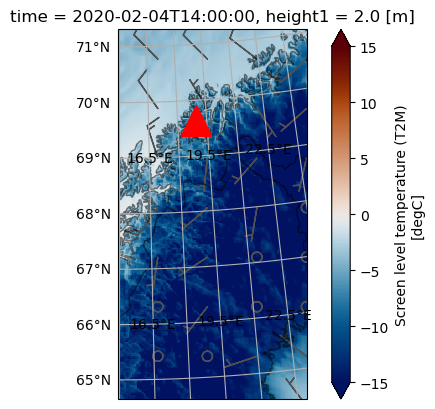

In [15]:
from cmcrameri import cm

projection = cy.crs.LambertConformal(central_longitude =ds_pl.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =ds_pl.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = ds_pl.projection_lambert.standard_parallel)
f, ax = plt.subplots(subplot_kw={'projection' : projection}, )
    
ax.set_extent([lon_tos - 4, lon_tos + 4, lat_tos-5, lat_tos+1.5], cy.crs.PlateCarree())
ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
ax.add_feature(cy.feature.BORDERS, alpha=0.5)
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False

# Plot 2-m temperature
(t2m.isel(time = timestep, height1=0)).plot(ax=ax, transform=projection, cmap=cm.vik, extend='both', vmin=-15, vmax=15)

# Plot wind barbs (the wind direction arrows)
XX, YY = np.meshgrid(ds_pl.x, ds_pl.y)
ax.barbs(XX[::40, ::40], YY[::40, ::40], ds_pl.x_wind_10m.isel(time = timestep, height7 = 0)[::40,::40], ds_pl.y_wind_10m.isel(time = timestep, height7 = 0)[::40,::40], barbcolor=[0.31372549, 0.31372549, 0.31764706])

# Tromsø station as triangle
ax.plot(lon_tos, lat_tos, color='red', marker='^', transform=cy.crs.PlateCarree(), markersize=22)

We're plotting the rest, using the same function we created at qn.4:

(The data we're using *are* the ones from 04/02/2020, initialized at 00:00 of that day.)

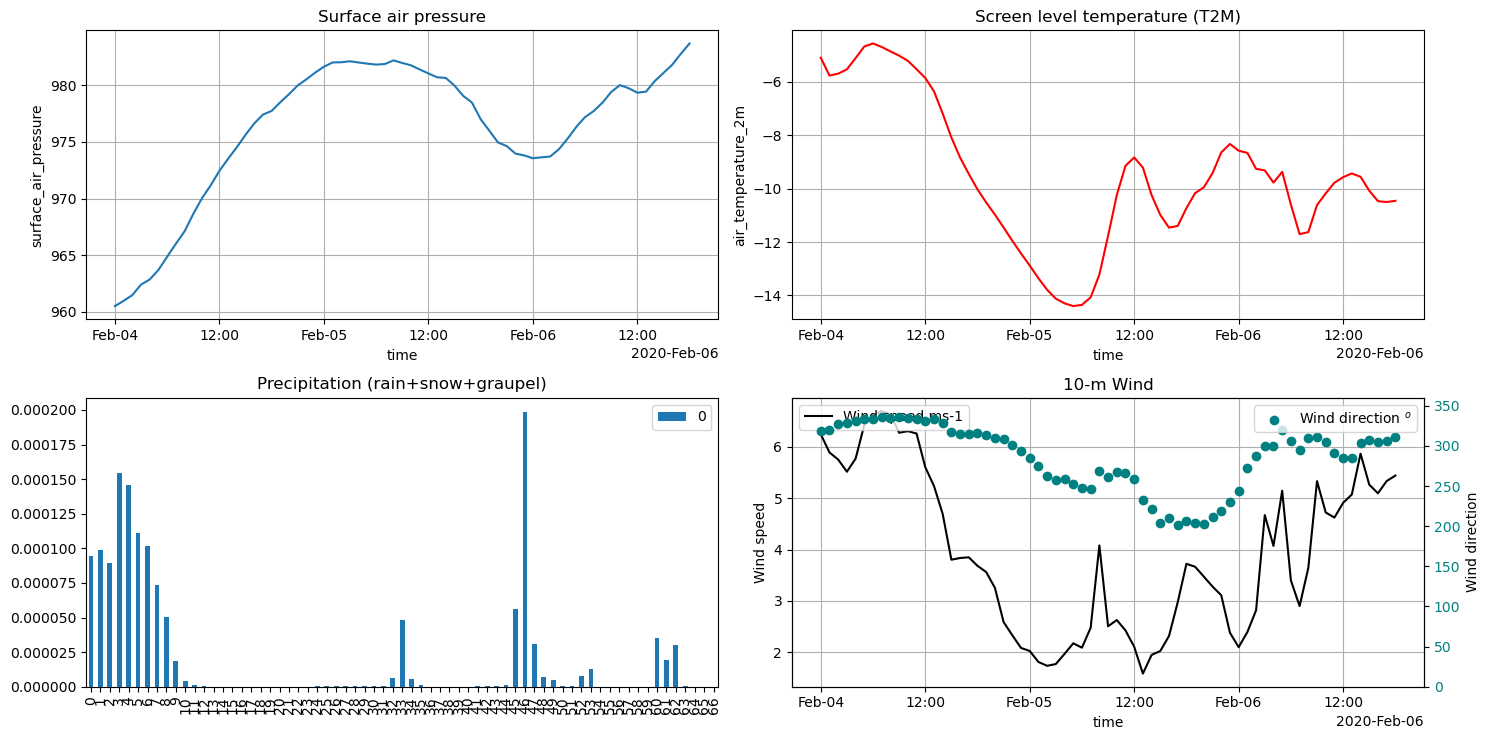

In [16]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[15,7.5], #sharex=True
                         )
plt_point_forecast(axsm, ds_pl, _xtos, _ytos)